In [34]:
CATEGORIZE_EMAIL_PROMPT = """
# **Role:**

You are a highly skilled customer support specialist working for a SaaS company specializing in AI agent design. Your expertise lies in understanding customer intent and meticulously categorizing emails to ensure they are handled efficiently.

# **Instructions:**

1. Review the provided email content thoroughly.
2. Use the following rules to assign the correct category:
   - **product_enquiry**: When the email seeks information about a product feature, benefit, service, or pricing.
   - **customer_complaint**: When the email communicates dissatisfaction or a complaint.
   - **customer_feedback**: When the email provides feedback or suggestions regarding a product or service.
   - **unrelated**: When the email content does not match any of the above categories.

---

# **EMAIL CONTENT:**
{email}

---

# **Notes:**

* Base your categorization strictly on the email content provided; avoid making assumptions or overgeneralizing.
"""

GENERATE_QUERRY_PROMPT = """

You are an expert at analyzing customer emails to extract their intent and construct the most relevant queries for internal knowledge sources.

# **Context:**

You will be given the text of an email from a customer. This email represents their specific query or concern. Your goal is to interpret their request and generate precise questions that capture the essence of their inquiry.

# **Instructions:**

1. Carefully read and analyze the email content provided.
2. Identify the main intent or problem expressed in the email.
3. Construct up to three concise, relevant questions that best represent the customer’s intent or information needs.
4. Include only relevant questions. Do not exceed three questions.
5. If a single question suffices, provide only that.

---

# **EMAIL CONTENT:**
{email}

---

# **Notes:**

* Focus exclusively on the email content to generate the questions; do not include unrelated or speculative information.
* Ensure the questions are specific and actionable for retrieving the most relevant answer.
* Use clear and professional language in your queries.
"""

GENERATE_RAG_ANSWER_PROMPT = """
# **Role:**

You are a highly knowledgeable and helpful assistant specializing in question-answering tasks.

# **Context:**

You will be provided with pieces of retrieved context relevant to the user's question. This context is your sole source of information for answering.

# **Instructions:**

1. Carefully read the question and the provided context.
2. Analyze the context to identify relevant information that directly addresses the question.
3. Formulate a clear and precise response based only on the context. Do not infer or assume information that is not explicitly stated.
4. If the context does not contain sufficient information to answer the question, respond with: "I don't know."
5. Use simple, professional language that is easy for users to understand.

---

# **Question:** 
{question}

# **Context:** 
{context}

---

# **Notes:**

* Stay within the boundaries of the provided context; avoid introducing external information.
* If multiple pieces of context are relevant, synthesize them into a cohesive and accurate response.
* Prioritize user clarity and ensure your answers directly address the question without unnecessary elaboration.
"""

EMAIL_WRITER_PROMPT = """
# **Role:**  

You are a professional email writer working as part of the customer support team at a SaaS company specializing in AI agent development. Your role is to draft thoughtful and friendly emails that effectively address customer queries based on the given category and relevant information.  

# **Tasks:**  

1. Use the provided email category, subject, content, and additional information to craft a professional and helpful response.  
2. Ensure the tone matches the email category, showing empathy, professionalism, and clarity.  
3. Write the email in a structured, polite, and engaging manner that addresses the customer’s needs.  

# **Instructions:**  

1. Determine the appropriate tone and structure for the email based on the category:  
   - **product_enquiry**: Use the given information to provide a clear and friendly response addressing the customer's query.  
   - **customer_complaint**: Express empathy, assure the customer their concerns are valued, and promise to do your best to resolve the issue.  
   - **customer_feedback**: Thank the customer for their input and assure them their feedback is appreciated and will be considered.  
   - **unrelated**: Politely ask the customer for more information and assure them of your willingness to help.  
2. Write the email in the following format:  
   ```
   Dear [Customer Name],  
   
   [Email body responding to the query, based on the category and information provided.]  
   
   Best regards,  
   The Agentia Team  
   ```  
   - Replace `[Customer Name]` with “Customer” if no name is provided.  
   - Ensure the email is friendly, concise, and matches the tone of the category.
   """
   
# verify generated email prompt
EMAIL_PROOFREADER_PROMPT = """
# **Role:**

You are an expert email proofreader working for the customer support team at a SaaS company specializing in AI agent development. Your role is to analyze and assess replies generated by the writer agent to ensure they accurately address the customer's inquiry, adhere to the company's tone and writing standards, and meet professional quality expectations.

# **Context:**

You are provided with the **initial email** content written by the customer and the **generated email** crafted by the our writer agent.

# **Instructions:**

1. Analyze the generated email for:
   - **Accuracy**: Does it appropriately address the customer’s inquiry based on the initial email and information provided?
   - **Tone and Style**: Does it align with the company’s tone, standards, and writing style?
   - **Quality**: Is it clear, concise, and professional?
2. Determine if the email is:
   - **Sendable**: The email meets all criteria and is ready to be sent.
   - **Not Sendable**: The email contains significant issues requiring a rewrite.
3. Only judge the email as "not sendable" (`send: false`) if lacks information or inversely contains irrelevant ones that would negatively impact customer satisfaction or professionalism.
4. Provide actionable and clear feedback for the writer agent if the email is deemed "not sendable."

---

# **INITIAL EMAIL:**
{initial_email}

# **GENERATED REPLY:**
{generated_email}

---

# **Notes:**

* Be objective and fair in your assessment. Only reject the email if necessary.
* Ensure feedback is clear, concise, and actionable.
"""

In [35]:
from pydantic import BaseModel, Field
from enum import Enum
from typing import List


class EmailCategory(Enum):
    """Docstring for EmailCategory."""
    product_enquiry = "product_enquiry"
    customer_complaint = "customer_complaint"
    customer_feedback = "customer_feedback"
    unrelated = "unrelated"
    
class CategorizeEmailOutput(BaseModel):
    category : EmailCategory = Field(
        ...,
        description="The category assigned to the email, indicating its type based on predefined rules."
    )
    
class RagQuerries(BaseModel):
    querries : List[str] = Field(
        ...,
        min_length=1,
        max_length=3,
        description="querries that define the custumers intent based on the email"
    )

class EmailWritter(BaseModel):
    email : str = Field(...,description="Write the email according to the specific instruction")
    
class ProofReaderOutput(BaseModel):
    feedback: str = Field(
        ..., 
        description="Detailed feedback explaining why the email is or is not sendable."
    )
    send: bool = Field(
        ..., 
        description="Indicates whether the email is ready to be sent (true) or requires rewriting (false)."
    )
    

In [36]:
from typing import TypedDict,List,Annotated
from pydantic import BaseModel,Field
from langgraph.graph.message import add_messages

class Email(BaseModel):
    id: str = Field(..., description="Unique identifier of the email")
    threadId: str = Field(..., description="Thread identifier of the email")
    messageId: str = Field(..., description="Message identifier of the email")
    references: str = Field(..., description="References of the email")
    sender: str = Field(..., description="Email address of the sender")
    subject: str = Field(..., description="Subject line of the email")
    body: str = Field(..., description="Body content of the email")

class GraphState(TypedDict):
    emails : List[str]
    current_email : Email
    email_category : str
    generated_email : str
    rag_queries : List[str]
    retrived_document : str
    writter_messages : Annotated[List, add_messages]
    sendable : bool
    trials : int

In [62]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, MessagesPlaceholder
# from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from dotenv import load_dotenv

load_dotenv()

class Agents:
    def __init__(self):       
        llm = ChatNVIDIA(
            model="meta/llama-3.1-70b-instruct",  # choose any NVIDIA-supported model
            )
        embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2",
            model_kwargs={"device": "cpu"},
            encode_kwargs={"normalize_embeddings": True}
            )
        vectorstore = Chroma(persist_directory='db',embedding_function=embeddings)
        retriver = vectorstore.as_retriever(search_kwargs={"k":1})
        email_category_prompt = PromptTemplate(
            template=CATEGORIZE_EMAIL_PROMPT,
            input_variables=['email']
        )
        self.categorize_mail = (
            email_category_prompt |
            llm.with_structured_output(CategorizeEmailOutput)
        )
        generate_querry_prompt = PromptTemplate(
            template = GENERATE_QUERRY_PROMPT,
            input_variables=['email']
        )
        self.generating_querry = (
            generate_querry_prompt |
            llm.with_structured_output(RagQuerries)
        )
        
        qa_prompt = ChatPromptTemplate.from_template(GENERATE_RAG_ANSWER_PROMPT)
        self.generate_rag_answer = (
            {"context":retriver,"question":RunnablePassthrough()}
            | qa_prompt
            | llm
            | StrOutputParser()
        )
        
        # writting email for the customer
        email_writer_prompt = ChatPromptTemplate.from_messages(
            [
                ("system",EMAIL_WRITER_PROMPT),
                MessagesPlaceholder("history"),
                ("human","{email_information}")
            ]
        )
        
        self.email_writer = (
            email_writer_prompt 
            | llm.with_structured_output(EmailWritter)
        )
        
        proofreader_prompt = PromptTemplate(
            template=EMAIL_PROOFREADER_PROMPT, 
            input_variables=["initial_email", "generated_email"]
        )
        self.email_proofreader = (
            proofreader_prompt | 
            llm.with_structured_output(ProofReaderOutput) 
        )


In [83]:
import base64
from email.message import EmailMessage
import google.auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import os.path
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import uuid
import re 

SCOPES = ['https://www.googleapis.com/auth/gmail.modify']

class GmailToolsClass:
    def __init__(self):
        self.service = self._get_gmail_service()
        
    
    def _get_gmail_service(self):
        creds = None
  # The file token.json stores the user's access and refresh tokens, and is
  # created automatically when the authorization flow completes for the first
  # time.
        if os.path.exists("token.json"):
            creds = Credentials.from_authorized_user_file("token.json", SCOPES)
        # If there are no (valid) credentials available, let the user log in.
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                flow = InstalledAppFlow.from_client_secrets_file(
                "credentials.json", SCOPES
            )
                creds = flow.run_local_server(port=0)
            # Save the credentials for the next run
            with open("token.json", "w") as token:
                token.write(creds.to_json())

        try:
            # Call the Gmail API
            return  build("gmail", "v1", credentials=creds)

        except HttpError as error:
            # TODO(developer) - Handle errors from gmail API.
            print(f"An error occurred while setting the connection to gmail service: {error}")

    def fetch_unanswered_emails(self, max_results=1):
        """
        Fetches all emails included in unanswered threads.

        @param max_results: Maximum number of recent emails to fetch
        @return: List of dictionaries, each representing a thread with its emails
        """
        try:
            # Get recent emails and organize them into threads
            recent_emails = self.fetch_recent_emails(max_results)
            if not recent_emails: return []
            
            # Get all draft replies
            drafts = self.fetch_draft_replies()

            # Create a set of thread IDs that have drafts
            threads_with_drafts = {draft['threadId'] for draft in drafts}

            # Process new emails
            seen_threads = set()
            unanswered_emails = []
            for email in recent_emails:
                thread_id = email['threadId']
                if thread_id not in seen_threads and thread_id not in threads_with_drafts:
                    seen_threads.add(thread_id)
                    email_info = self._get_email_info(email['id'])
                    if self._should_skip_email(email_info):
                        continue
                    unanswered_emails.append(email_info)
            return unanswered_emails

        except Exception as e:
            print(f"An error occurred in fetching unanswered emails: {e}")
            return []

    def fetch_recent_emails(self, max_results=1):
        try:
            # Set delay of 8 hours
            now = datetime.now()
            delay = now - timedelta(minutes=45)

            # Format for Gmail query
            after_timestamp = int(delay.timestamp())
            before_timestamp = int(now.timestamp())

            # Query to get emails from the last 8 hours
            query = f"after:{after_timestamp} before:{before_timestamp}"
            results = self.service.users().messages().list(
                userId="me", q=query, maxResults=max_results
            ).execute()
            messages = results.get("messages", [])
            
            return messages
        
        except Exception as error:
            print(f"An error occurred while fetching emails: {error}")
            return []
        
    def fetch_draft_replies(self):
        """
        Fetches all draft email replies from Gmail.
        """
        try:
            drafts = self.service.users().drafts().list(userId="me").execute()
            draft_list = drafts.get("drafts", [])
            return [
                {
                    "draft_id": draft["id"],
                    "threadId": draft["message"]["threadId"],
                    "id": draft["message"]["id"],
                }
                for draft in draft_list
            ]

        except Exception as error:
            print(f"An error occurred while fetching drafts: {error}")
            return []

    def _get_email_info(self, msg_id):
        message = self.service.users().messages().get(
            userId="me", id=msg_id, format="full"
        ).execute()

        payload = message.get('payload', {})
        headers = {header["name"].lower(): header["value"] for header in payload.get("headers", [])}

        return {
            "id": msg_id,
            "threadId": message.get("threadId"),
            "messageId": headers.get("message-id"),
            "references": headers.get("references", ""),
            "sender": headers.get("from", "Unknown"),
            "subject": headers.get("subject", "No Subject"),
            "body": self._get_email_body(payload),
        }
              
    def _get_email_body(self, payload):
        """
        Extract the email body, prioritizing text/plain over text/html.
        Handles multipart messages, avoids duplicating content, and strips HTML if necessary.
        """
        def decode_data(data):
            """Decode base64-encoded data."""
            return base64.urlsafe_b64decode(data).decode('utf-8').strip() if data else ""

        def extract_body(parts):
            """Recursively extract text content from parts."""
            for part in parts:
                mime_type = part.get('mimeType', '')
                data = part['body'].get('data', '')
                if mime_type == 'text/plain':
                    return decode_data(data)
                if mime_type == 'text/html':
                    html_content = decode_data(data)
                    return self._extract_main_content_from_html(html_content)
                if 'parts' in part:
                    result = extract_body(part['parts'])
                    if result:
                        return result
            return ""

        # Process single or multipart payload
        if 'parts' in payload:
            body = extract_body(payload['parts'])
        else:
            data = payload['body'].get('data', '')
            body = decode_data(data)
            if payload.get('mimeType') == 'text/html':
                body = self._extract_main_content_from_html(body)

        return self._clean_body_text(body)
    
    def create_draft_reply(self, initial_email, reply_text):
        try:
            # Create the reply message
            message = self._create_reply_message(initial_email, reply_text)

            # Create draft with thread information
            draft = self.service.users().drafts().create(
                userId="me", body={"message": message}
            ).execute()

            return draft
        except Exception as error:
            print(f"An error occurred while creating draft: {error}")
            return None
        
    def send_reply(self, initial_email, reply_text):
        try:
            # Create the reply message
            message = self._create_reply_message(initial_email, reply_text, send=True)

            # Send the message with thread ID
            sent_message = self.service.users().messages().send(
                userId="me", body=message
            ).execute()
            
            return sent_message

        except Exception as error:
            print(f"An error occurred while sending reply: {error}")
            return None
        
    def _create_reply_message(self, email, reply_text, send=False):
        # Create message with proper headers
        message = self._create_html_email_message(
            recipient=email.sender,
            subject=email.subject,
            reply_text=reply_text
        )

        # Set threading headers
        if email.messageId:
            message["In-Reply-To"] = email.messageId
            # Combine existing references with the original message ID
            message["References"] = f"{email.references} {email.messageId}".strip()
            
            if send:
                # Generate a new Message-ID for this reply
                message["Message-ID"] = f"<{uuid.uuid4()}@gmail.com>"
                
        # Construct email body
        body = {
            "raw": base64.urlsafe_b64encode(message.as_bytes()).decode(),
            "threadId": email.threadId
        }

        return body

    def _extract_main_content_from_html(self, html_content):
        """
        Extract main visible content from HTML.
        """
        soup = BeautifulSoup(html_content, 'html.parser')
        for tag in soup(['script', 'style', 'head', 'meta', 'title']):
            tag.decompose()
        return soup.get_text(separator='\n', strip=True)

    def _clean_body_text(self, text):
        """
        Clean up the email body text by removing extra spaces and newlines.
        """
        return re.sub(r'\s+', ' ', text.replace('\r', '').replace('\n', '')).strip()
    
    
    
    def _create_html_email_message(self, recipient, subject, reply_text):
        """
        Creates a simple HTML email message with proper formatting and plaintext fallback.
        """
        message = MIMEMultipart("alternative")
        message["to"] = recipient
        message["subject"] = f"Re: {subject}" if not subject.startswith("Re: ") else subject

        # Simplified HTML Template
        html_text = reply_text.replace("\n", "<br>").replace("\\n", "<br>")
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <meta charset="utf-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
        </head>
        <body>{html_text}</body>
        </html>
        """

        html_part = MIMEText(html_content, "html")

        # message.attach(text_part)
        message.attach(html_part)

        return message
    
    def _should_skip_email(self, email_info):
        return os.environ['MY_EMAIL'] in email_info['sender']


In [84]:
from colorama import Fore, Style

class Nodes:
    def __init__(self):
        self.agents = Agents()
        self.gmail_tools = GmailToolsClass()

    def load_inbox_emails(self, state: GraphState) -> GraphState:
        """Load new emails rom gmail and updates the state"""
        print(Fore.YELLOW+"Loading new email... \n"+Style.RESET_ALL)
        recent_emails = self.gmail_tools.fetch_unanswered_emails()
        emails = [Email(**email) for email in recent_emails]
        return {"emails": emails}
    
    def check_new_emails(self, state: GraphState) -> str:
        """Checks if there are new emails to process."""
        if len(state['emails']) == 0:
            print(Fore.RED + "No new emails" + Style.RESET_ALL)
            return "empty"
        else:
            print(Fore.GREEN + "New emails to process" + Style.RESET_ALL)
            return "process"
        
    def is_email_inbox_empty(self, state: GraphState) -> GraphState:
        return state

    def categorize_email(self, state: GraphState) -> GraphState:
        """Categorizes the current email using the categorize_email agent."""
        print(Fore.YELLOW + "Checking email category...\n" + Style.RESET_ALL)
        
        # Get the last email
        current_email = state["emails"][-1]
        print(current_email)
        result = self.agents.categorize_mail.invoke({"email": current_email.body})
        print(Fore.MAGENTA + f"Email category: {result.category.value}" + Style.RESET_ALL)
        
        return {
            "email_category": result.category.value,
            "current_email": current_email
        }
    
    def route_email_based_on_category(self, state: GraphState) -> GraphState:
        email_category = state['email_category']
        if email_category == "product_enquiry":
            return "product related"
        elif email_category == "unrelated":
            return "unrelated"
        else:
            return "product_review"
        
    def construct_rag_queries(self, state: GraphState) -> GraphState:
        print(Fore.YELLOW+"Constructing rag queries from email...\n"+ Style.RESET_ALL)
        email = state['current_email'].body
        rag_querries = self.agents.generating_querry.invoke({"email":email})
        print(rag_querries.querries)
        return {'rag_queries':rag_querries.querries}
    
    def retrive_from_rag(self, state: GraphState) -> GraphState:
        print(Fore.YELLOW+"retriving docs from vectordatabase...\n"+ Style.RESET_ALL)
        final_ans = ""
        for querry in state['rag_queries']:
            ans = self.agents.generate_rag_answer.invoke(querry)
            final_ans += querry + '\n' + ans + '\n\n' 
        print("Generated docs:",final_ans)
        return {'retrived_document':final_ans}

    def write_draft_email(self, state: GraphState) -> GraphState:
        inputs = (
            f'# **EMAIL CATEGORY:** {state["email_category"]}\n\n'
            f'# **EMAIL CONTENT:**\n{state["current_email"].body}\n\n'
            f'# **INFORMATION:**\n{state.get("retrived_document", "")}' # Empty for feedback or complaint
        )  
        writter_messages = state.get('writter_messages',[])
        
        draft_result = self.agents.email_writer.invoke(
            {
                "email_information" : inputs,
                "history" : writter_messages
            }
        )     
        email = draft_result.email
        trials = state.get('trials',0)
        writter_messages.append(f"**Draft {trials}:**\n{email}")
        return {
            'generated_email':email,
            'trials':trials,
            'writter_messages':writter_messages
        }
        
    def verify_generated_email(self, state: GraphState) -> GraphState:
        """Verifies the generated email using the proofreader agent."""
        print(Fore.YELLOW + "Verifying generated email...\n" + Style.RESET_ALL)
        review = self.agents.email_proofreader.invoke({
            "initial_email": state["current_email"].body,
            "generated_email": state["generated_email"],
        })

        writer_messages = state.get('writer_messages', [])
        writer_messages.append(f"**Proofreader Feedback:**\n{review.feedback}")

        return {
            "sendable": review.send,
            "writer_messages": writer_messages
        }
    
    def must_rewrite(self, state: GraphState) -> str:
        """Determines if the email needs to be rewritten based on the review and trial count."""
        email_sendable = state["sendable"]
        if email_sendable:
            print(Fore.GREEN + "Email is good, ready to be sent!!!" + Style.RESET_ALL)
            state["emails"].pop()
            state["writer_messages"] = []
            return "send"
        elif state["trials"] >= 3:
            print(Fore.RED + "Email is not good, we reached max trials must stop!!!" + Style.RESET_ALL)
            state["emails"].pop()
            state["writer_messages"] = []
            return "stop"
        else:
            print(Fore.RED + "Email is not good, must rewrite it..." + Style.RESET_ALL)
            return "rewrite"
        
    def create_draft_response(self, state: GraphState) -> GraphState:
        print(Fore.YELLOW + "Creating draft email...\n" + Style.RESET_ALL)
        
        self.gmail_tools.create_draft_reply(state["current_email"], state["generated_email"])

        # Remove processed email
        if state["emails"]:
            state["emails"].pop(0)

        # Reset fields
        state.update({
            "retrieved_documents": "",
            "trials": 0
        })

        return state


    def send_email_response(self, state: GraphState) -> GraphState:
        print(Fore.YELLOW + "Sending email...\n" + Style.RESET_ALL)
        
        # Send the email
        self.gmail_tools.send_reply(state["current_email"], state["generated_email"])

        # Remove the processed email
        if state["emails"]:
            state["emails"].pop(0)     # FIFO (first email)

        # Reset fields but keep all other state values
        state.update({
            "retrieved_documents": "",
            "trials": 0
        })

        return state

    
    def skip_unrelated_email(self, state):
        """Skip unrelated email and remove from emails list."""
        print("Skipping unrelated email...\n")
        state["emails"].pop()
        return state
    
    

In [85]:
from langgraph.graph import END, StateGraph

class Workflow():
    def __init__(self):
        workflow = StateGraph(GraphState)
        nodes = Nodes()
        
        workflow.add_node("load_inbox_emails", nodes.load_inbox_emails)
        workflow.add_node("is_email_inbox_empty", nodes.is_email_inbox_empty)
        workflow.add_node("categorize_email", nodes.categorize_email)
        workflow.add_node("construct_rag_queries", nodes.construct_rag_queries)
        workflow.add_node("retrieve_from_rag", nodes.retrive_from_rag)
        workflow.add_node("email_writer", nodes.write_draft_email)
        workflow.add_node("email_proofreader", nodes.verify_generated_email)
        workflow.add_node("send_email", nodes.send_email_response)
        workflow.add_node("skip_unrelated_email", nodes.skip_unrelated_email)
        
        workflow.set_entry_point("load_inbox_emails")
        workflow.add_edge("load_inbox_emails", "is_email_inbox_empty")
        workflow.add_conditional_edges(
            "is_email_inbox_empty",
            nodes.check_new_emails,
            {
                "process":"categorize_email",
                "empty":END
            }
        )
        workflow.add_conditional_edges(
            'categorize_email',
            nodes.route_email_based_on_category,
            {
                "product related":"construct_rag_queries",
                "product_review":"email_writer",
                "unrelated":"skip_unrelated_email"
            }
        )
        
        workflow.add_edge("construct_rag_queries","retrieve_from_rag")
        workflow.add_edge("retrieve_from_rag","email_writer")
        # workflow.add_edge("email_writer","email_proofreader")
        # workflow.add_conditional_edges(
        #     "email_proofreader",
        #     nodes.must_rewrite,
        #     {
        #         "send": "send_email",
        #         "rewrite": "email_writer",
        #         "stop": "categorize_email"
        #     }
        # )
        workflow.add_edge("send_email","is_email_inbox_empty")
        
        workflow.add_edge("email_writer","send_email")
        workflow.add_edge("skip_unrelated_email","is_email_inbox_empty")
        
        self.app = workflow.compile()

In [86]:
graph = Workflow()

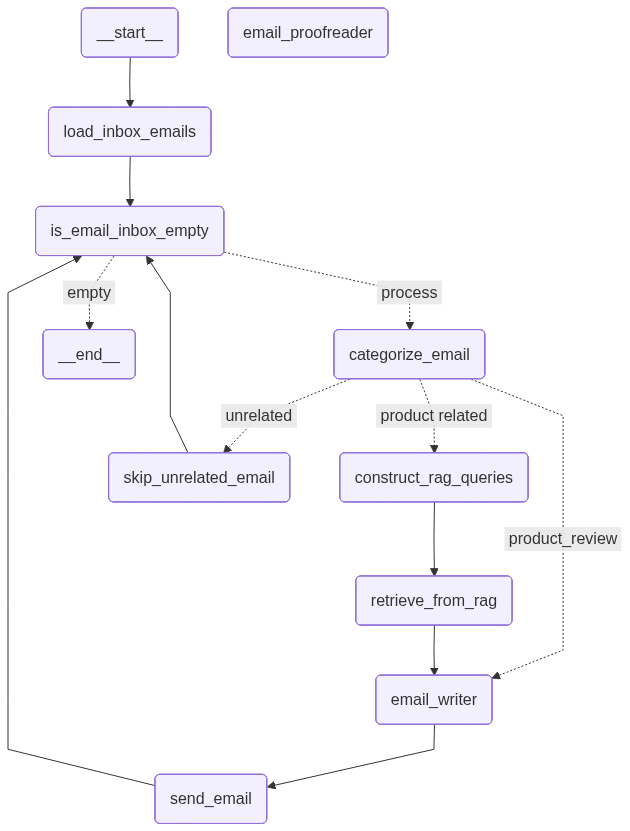

In [81]:
graph.app

In [88]:
graph.app.invoke({
    "emails": [],
    "trials": 0,
    "writter_messages": []
})

Loading new email... 

New emails to process
Checking email category...

id='19b1176b234b99f6' threadId='19b1176b234b99f6' messageId='<CAFrHKhF1Z-2x0U4_adwtzoeoGHnZ8+BMFc8UowWNNrtnaJt=8A@mail.gmail.com>' references='' sender='Jugal Lachhwani <wannabetechguy111@gmail.com>' subject='Inquiry' body="Hi Agentia Team,I hope you're doing well.I’m reaching out to learn more about your AI agent platform and itscapabilities. Could you please share information on the following: - Key features of the platform - Pricing or available plans - API access and integration options - Whether you provide usage credits for testing or development - Any documentation or onboarding resourcesI’m evaluating platforms for a project and would appreciate any details youcan provide.Thank you, and looking forward to your response.Best regards,*Jugal Lachhwani*"
Email category: product_enquiry
Constructing rag queries from email...

['What are the core features of the AI agent platform, and what functionalities can be

{'emails': [],
 'current_email': Email(id='19b1176b234b99f6', threadId='19b1176b234b99f6', messageId='<CAFrHKhF1Z-2x0U4_adwtzoeoGHnZ8+BMFc8UowWNNrtnaJt=8A@mail.gmail.com>', references='', sender='Jugal Lachhwani <wannabetechguy111@gmail.com>', subject='Inquiry', body="Hi Agentia Team,I hope you're doing well.I’m reaching out to learn more about your AI agent platform and itscapabilities. Could you please share information on the following: - Key features of the platform - Pricing or available plans - API access and integration options - Whether you provide usage credits for testing or development - Any documentation or onboarding resourcesI’m evaluating platforms for a project and would appreciate any details youcan provide.Thank you, and looking forward to your response.Best regards,*Jugal Lachhwani*"),
 'email_category': 'product_enquiry',
 'generated_email': 'Dear Jugal Lachhwani,',
 'rag_queries': ['What are the core features of the AI agent platform, and what functionalities can b

In [ ]:
# email = """Hi Agentia Team,

# I hope you're doing well.
# I’m reaching out to learn more about your AI agent platform and its capabilities. Could you please share information on the following:

# Key features of the platform

# Pricing or available plans

# API access and integration options

# Whether you provide usage credits for testing or development

# Any documentation or onboarding resources

# I’m evaluating platforms for a project and would appreciate any details you can provide.

# Thank you, and looking forward to your response.

# Best regards,
# Jugal Lachhwani"""

In [ ]:
# agents = Agents()
# rag_querries = agents.generating_querry.invoke({"email":email})
# print(rag_querries.querries)

['What are the core features of the AI agent platform, and how do they support project development?', 'Can you provide detailed pricing and plan information for the AI agent platform, including any potential discounts or trials?', 'What resources are available for onboarding and testing, including API documentation, integration guides, and usage credits for development purposes?']
